In [1]:
import torch, torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

In [2]:
train_dataset = datasets.CIFAR10(root = "cifar/", train = True, download = True, transform = transforms.ToTensor())
test_dataset = datasets.CIFAR10(root = "cifar/", train = False, download = True, transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 128, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 128, shuffle = False)

classes = train_dataset.classes
print(classes)

Files already downloaded and verified
Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [3]:
class Network(torch.nn.Module):
  def __init__(self):
    super(Network, self).__init__()
    self.dense1 = torch.nn.Linear(32*32*3, 512)
    self.dense2 = torch.nn.Linear(512, 512)
    self.dense3 = torch.nn.Linear(512, 10)     
    self.relu = torch.nn.ReLU()

  def forward(self, x):
    x = x.view(x.size(0), 32*32*3)
    x = self.dense1(x)
    x = self.relu(x)
    x = self.dense2(x)
    x = self.relu(x)
    x = self.dense3(x)
    x = torch.nn.functional.log_softmax(x)
    return x

In [4]:
def train(model, dataloader, optimizer, epoch, l1_decay):
    avgLoss = 0.0
    for i, (images, labels) in enumerate(dataloader):
        images, labels = images.float().to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        prediction = model.forward(images)
        loss = criterion(prediction, labels)

        if l1_decay is not None:
            l_reg_loss = 0
            for param in model.parameters():
                l_reg_loss += torch.norm(param, 1)
            loss += l1_decay * l_reg_loss

        loss.backward()
        optimizer.step()
        avgLoss += loss.item()*images.size(0)
        
    avgLoss = avgLoss/len(train_loader.dataset)
    print("epoch: {} and loss: {}".format(epoch+1, avgLoss))
    return avgLoss

In [5]:
def evaluate(model, test_loader, optimizer):
    model.eval()
    loss_rate = 0.
    correct_rate = 0.

    for image_test, label_test in test_loader:
        image_test = image_test.float().to(DEVICE)
        label_test = label_test.to(DEVICE)
        optimizer.zero_grad()
        prediction = model.forward(image_test)
        loss = criterion(prediction, label_test)
        loss.backward()
        optimizer.step()
        loss_rate += loss.item()*image_test.size(0)
        _, label_pred = torch.max(prediction, 1)
        correct_rate += torch.eq(label_pred, label_test.data).sum()
    loss_rate = loss_rate/len(test_loader.dataset)
    accuracy = 100.*correct_rate / len(test_loader.dataset)
    print('Average loss: {}, Accuracy: {}/{} = {:.0f}%'.format(loss_rate, 
    correct_rate, len(test_loader.dataset), accuracy))
    return accuracy

In [6]:
if __name__ == '__main__':
    DEVICE = torch.device('cuda')
    criterion = torch.nn.CrossEntropyLoss()

In [7]:
    epoch_num = 25
    loss_array = [[None]*epoch_num for _ in range(4)]
    loss_val = [0]*epoch_num
    optimizer_array = []
    model = [Network().to(DEVICE) for i in range(4)]

    optimizer_array.append(torch.optim.SGD(model[0].parameters(), lr=0.01))
    optimizer_array.append(torch.optim.SGD(model[1].parameters(), lr=0.01, momentum=0.9, nesterov=True))
    optimizer_array.append(torch.optim.SGD(model[2].parameters(), lr=0.01, momentum=0.9, nesterov=True))
    optimizer_array.append(torch.optim.SGD(model[3].parameters(), lr=0.01, momentum=0.9, nesterov=True, weight_decay=0.001))

    for i in range(4):
        print('Avg loss', i+1)
        for epoch in range(epoch_num):
            avg_loss = train(model[i], train_loader, optimizer_array[i], epoch, None)
            if i == 2:
                avg_loss = train(model[i], train_loader, optimizer_array[i], epoch, 0.01)
            loss_array[i][epoch] = avg_loss
            loss_val[i] += avg_loss
        print('avg_loss{}: '.format(i+1), loss_val[i]/len(loss_array[i]))
        print('')

Avg loss 1
epoch: 1 and loss: 2.203470922393799
epoch: 2 and loss: 2.0067795215606687
epoch: 3 and loss: 1.9127591201019287
epoch: 4 and loss: 1.8588822854232787
epoch: 5 and loss: 1.8187606857299805
epoch: 6 and loss: 1.7822231344223023
epoch: 7 and loss: 1.7511518907928467
epoch: 8 and loss: 1.721536718826294
epoch: 9 and loss: 1.6950915969467164
epoch: 10 and loss: 1.6715950254058838
epoch: 11 and loss: 1.6497582248306275
epoch: 12 and loss: 1.6289883935165406
epoch: 13 and loss: 1.610268186454773
epoch: 14 and loss: 1.590853466644287
epoch: 15 and loss: 1.5735723106002808
epoch: 16 and loss: 1.5592292951202393
epoch: 17 and loss: 1.5443184977340698
epoch: 18 and loss: 1.5287825539779663
epoch: 19 and loss: 1.5153855081939698
epoch: 20 and loss: 1.5012388038635254
epoch: 21 and loss: 1.4907155883026124
epoch: 22 and loss: 1.4747539615631104
epoch: 23 and loss: 1.4648849658966066
epoch: 24 and loss: 1.4524591704559326
epoch: 25 and loss: 1.440511077041626
avg_loss1:  1.65791883623199

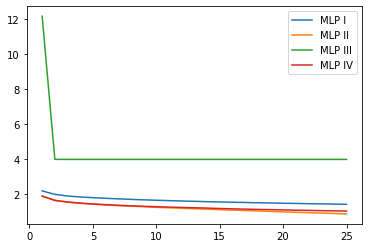

In [8]:
    figure, x = plt.subplots(1, 1)
    x.plot(range(1, epoch_num+1), loss_array[0], label='MLP I')
    x.plot(range(1, epoch_num+1), loss_array[1], label='MLP II')
    x.plot(range(1, epoch_num+1), loss_array[2], label='MLP III')
    x.plot(range(1, epoch_num+1), loss_array[3], label='MLP IV')
    plt.legend(['MLP I', 'MLP II', 'MLP III', 'MLP IV'], loc='upper right')	
    plt.show()

In [9]:
    epoch_num = 25
    accuracy_array = [[None]*epoch_num for _ in range(4)]
    acc_val = [0]*epoch_num

    for i in range(4):
        print('Avg loss', i+1)
        for epoch in range(epoch_num):
            avg_accuracy = evaluate(model[i], test_loader, optimizer_array[i])
            accuracy_array[i][epoch] = avg_accuracy
            acc_val[i] += avg_accuracy
        print('avg_loss{}: %'.format(i+1), (acc_val[i]/len(accuracy_array[i])).cpu().numpy())
        print('')

Avg loss 1
Average loss: 1.4703868673324585, Accuracy: 4806.0/10000 = 48%
Average loss: 1.461020053100586, Accuracy: 4842.0/10000 = 48%
Average loss: 1.4503399871826173, Accuracy: 4876.0/10000 = 49%
Average loss: 1.4405755039215087, Accuracy: 4908.0/10000 = 49%
Average loss: 1.4317171255111694, Accuracy: 4945.0/10000 = 49%
Average loss: 1.4239382263183593, Accuracy: 4969.0/10000 = 50%
Average loss: 1.4156794717788697, Accuracy: 5004.0/10000 = 50%
Average loss: 1.4083355028152467, Accuracy: 5057.0/10000 = 51%
Average loss: 1.401251927280426, Accuracy: 5080.0/10000 = 51%
Average loss: 1.3943578443527223, Accuracy: 5110.0/10000 = 51%
Average loss: 1.3873646594047546, Accuracy: 5125.0/10000 = 51%
Average loss: 1.3810202575683594, Accuracy: 5153.0/10000 = 52%
Average loss: 1.37433582239151, Accuracy: 5175.0/10000 = 52%
Average loss: 1.3681602780342101, Accuracy: 5216.0/10000 = 52%
Average loss: 1.3620073163032531, Accuracy: 5239.0/10000 = 52%
Average loss: 1.3557703733444213, Accuracy: 5266

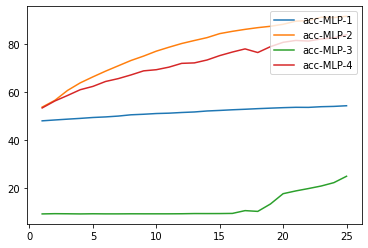

In [11]:
    figure, y = plt.subplots(1, 1)
    y.plot(range(1, 26), accuracy_array[0], label='acc-MLP-1')
    y.plot(range(1, 26), accuracy_array[1], label='acc-MLP-2')
    y.plot(range(1, 26), accuracy_array[2], label='acc-MLP-3')
    y.plot(range(1, 26), accuracy_array[3], label='acc-MLP-4')
    plt.legend(['acc-MLP-1', 'acc-MLP-2', 'acc-MLP-3', 'acc-MLP-4'], loc='upper right')	
    plt.show()

1) Question 1

In [12]:
    model5 = Network().to(DEVICE)
    model6 = Network().to(DEVICE)
    model7 = Network().to(DEVICE)
    model8 = Network().to(DEVICE)

In [13]:
    optimizer5 = torch.optim.Adam(model5.parameters(), lr=0.01)
    loss5 = []
    loss5_val = 0
    for epoch in range(50):
        avg_loss5 = train(model5, train_loader, optimizer5, epoch, None)
        loss5.append(avg_loss5)
        loss5_val += avg_loss5
    print('avg_loss5: ', loss5_val/len(loss5))

epoch: 1 and loss: 2.5332557469177246
epoch: 2 and loss: 2.3032895115661622
epoch: 3 and loss: 2.3033768769836427
epoch: 4 and loss: 2.3030654028320314
epoch: 5 and loss: 2.303382843093872
epoch: 6 and loss: 2.303368022918701
epoch: 7 and loss: 2.3034078760528565
epoch: 8 and loss: 2.3034185953521726
epoch: 9 and loss: 2.303234321594238
epoch: 10 and loss: 2.303376517944336
epoch: 11 and loss: 2.303472352218628
epoch: 12 and loss: 2.3033749086761475
epoch: 13 and loss: 2.303402566604614
epoch: 14 and loss: 2.3034176529693604
epoch: 15 and loss: 2.3032671465301515
epoch: 16 and loss: 2.3033355460357665
epoch: 17 and loss: 2.3032548892211913
epoch: 18 and loss: 2.303244298477173
epoch: 19 and loss: 2.303206367263794
epoch: 20 and loss: 2.303228960266113
epoch: 21 and loss: 2.303284314727783
epoch: 22 and loss: 2.3034434381866453
epoch: 23 and loss: 2.303303207244873
epoch: 24 and loss: 2.3033142951965333
epoch: 25 and loss: 2.303167516937256
epoch: 26 and loss: 2.303390547027588
epoch: 2

In [14]:
    optimizer6 = torch.optim.Adam(model6.parameters(), lr=0.01, betas=(0.9,0.99))
    loss6 = []
    loss6_val = 0
    for epoch in range(50):
        avg_loss6 = train(model6, train_loader, optimizer6, epoch, None)
        loss6.append(avg_loss6)
        loss6_val += avg_loss6
    print('avg_loss6: ', loss6_val/len(loss6))

epoch: 1 and loss: 2.24912466003418
epoch: 2 and loss: 1.9133640045928955
epoch: 3 and loss: 1.8900951245880127
epoch: 4 and loss: 1.8765556509780883
epoch: 5 and loss: 1.874780771560669
epoch: 6 and loss: 1.8773736835098267
epoch: 7 and loss: 1.8649858460235595
epoch: 8 and loss: 1.859884026145935
epoch: 9 and loss: 1.8491481225585937
epoch: 10 and loss: 1.8557435885620117
epoch: 11 and loss: 1.8614891217422485
epoch: 12 and loss: 1.8614051022338867
epoch: 13 and loss: 1.851263201637268
epoch: 14 and loss: 1.859425549583435
epoch: 15 and loss: 1.8538279206085204
epoch: 16 and loss: 1.8592232009887695
epoch: 17 and loss: 1.8490722512054443
epoch: 18 and loss: 1.855263135948181
epoch: 19 and loss: 1.8457996069717406
epoch: 20 and loss: 1.8415277002716064
epoch: 21 and loss: 1.844414024963379
epoch: 22 and loss: 1.8514525156402588
epoch: 23 and loss: 1.8399132943344116
epoch: 24 and loss: 1.8469252600479127
epoch: 25 and loss: 1.842588508911133
epoch: 26 and loss: 1.8389929086685182
epoc

In [15]:
    optimizer7 = torch.optim.Adam(model7.parameters(), lr=0.01, betas=(0.9,0.99))
    loss7 = []
    loss7_val = 0
    for epoch in range(50):
        avg_loss7 = train(model7, train_loader, optimizer7, epoch, 0.01)
        loss7.append(avg_loss7)
        loss7_val += avg_loss7
    print('avg_loss7: ', loss7_val/len(loss7))

epoch: 1 and loss: 28.945379470214842
epoch: 2 and loss: 26.09566677734375
epoch: 3 and loss: 26.018174204711915
epoch: 4 and loss: 25.962092149658204
epoch: 5 and loss: 25.928489013061522
epoch: 6 and loss: 25.89034137878418
epoch: 7 and loss: 25.857387529296876
epoch: 8 and loss: 25.83621962890625
epoch: 9 and loss: 25.81522090576172
epoch: 10 and loss: 25.798587346801757
epoch: 11 and loss: 25.77641220703125
epoch: 12 and loss: 25.75612240234375
epoch: 13 and loss: 25.736810287475585
epoch: 14 and loss: 25.721609140625
epoch: 15 and loss: 25.711770849609376
epoch: 16 and loss: 25.69529841430664
epoch: 17 and loss: 25.685953107299806
epoch: 18 and loss: 25.669441219482422
epoch: 19 and loss: 25.6596360559082
epoch: 20 and loss: 25.648246744995117
epoch: 21 and loss: 25.640595837402344
epoch: 22 and loss: 25.636754037475587
epoch: 23 and loss: 25.63271306274414
epoch: 24 and loss: 25.61812721862793
epoch: 25 and loss: 25.603084606933592
epoch: 26 and loss: 25.593240735473632
epoch: 27

In [16]:
    optimizer8 = torch.optim.Adam(model8.parameters(), lr=0.01, weight_decay=0.001, betas=(0.9,0.99))
    loss8 = []
    loss8_val = 0
    for epoch in range(50):
        avg_loss8 = train(model8, train_loader, optimizer8, epoch, None)
        loss8.append(avg_loss8)
        loss8_val += avg_loss8
    print('avg_loss8: ', loss8_val/len(loss8))

epoch: 1 and loss: 2.2570490773773195
epoch: 2 and loss: 1.963141400756836
epoch: 3 and loss: 1.987424955291748
epoch: 4 and loss: 2.0096966918182373
epoch: 5 and loss: 1.990653250465393
epoch: 6 and loss: 1.9973368882751465
epoch: 7 and loss: 1.9941190064239502
epoch: 8 and loss: 1.9837772631835937
epoch: 9 and loss: 2.0125708858489992
epoch: 10 and loss: 1.9847030178070069
epoch: 11 and loss: 2.016960188446045
epoch: 12 and loss: 1.9887558032989503
epoch: 13 and loss: 1.997339323120117
epoch: 14 and loss: 1.9929626947021484
epoch: 15 and loss: 1.995992790298462
epoch: 16 and loss: 1.9947498657989502
epoch: 17 and loss: 2.009873218612671
epoch: 18 and loss: 1.9971377377319337
epoch: 19 and loss: 1.982162697982788
epoch: 20 and loss: 2.0023361850738524
epoch: 21 and loss: 1.994034953956604
epoch: 22 and loss: 1.9903454889297485
epoch: 23 and loss: 1.9994141629028321
epoch: 24 and loss: 1.9964570922851563
epoch: 25 and loss: 2.0038724434661863
epoch: 26 and loss: 2.0000515546417237
epoc

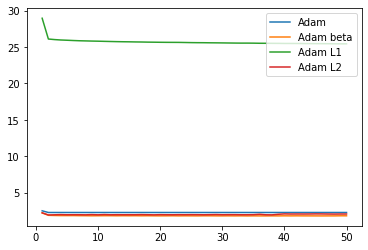

In [17]:
    figure, t = plt.subplots(1, 1)
    t.plot(range(1, 51), loss5, label='Adam')
    t.plot(range(1, 51), loss6, label='Adam beta')
    t.plot(range(1, 51), loss7, label='Adam L1')
    t.plot(range(1, 51), loss8, label='Adam L2')
    plt.legend(['Adam', 'Adam beta', 'Adam L1', 'Adam L2'], loc='upper right')	
    plt.show()

In [22]:
    accuracy5 = []
    acc5_val = 0
    for epoch in range(50):
        avg_accuracy5 = evaluate(model5, test_loader, optimizer5)
        accuracy5.append(avg_accuracy5)
        acc5_val += avg_accuracy5
    print('avg_acc5: %', (acc5_val/len(accuracy5)).cpu().numpy())

Average loss: 2.303708292388916, Accuracy: 958.0/10000 = 10%
Average loss: 2.3037082469940184, Accuracy: 958.0/10000 = 10%
Average loss: 2.303708222579956, Accuracy: 958.0/10000 = 10%
Average loss: 2.3037081733703615, Accuracy: 958.0/10000 = 10%
Average loss: 2.3037081398010253, Accuracy: 958.0/10000 = 10%
Average loss: 2.303708102416992, Accuracy: 958.0/10000 = 10%
Average loss: 2.3037080322265626, Accuracy: 958.0/10000 = 10%
Average loss: 2.3037080116271973, Accuracy: 958.0/10000 = 10%
Average loss: 2.3037079807281495, Accuracy: 958.0/10000 = 10%
Average loss: 2.303707904052734, Accuracy: 958.0/10000 = 10%
Average loss: 2.3037078773498534, Accuracy: 958.0/10000 = 10%
Average loss: 2.303707873916626, Accuracy: 958.0/10000 = 10%
Average loss: 2.303707880020142, Accuracy: 958.0/10000 = 10%
Average loss: 2.303707870864868, Accuracy: 958.0/10000 = 10%
Average loss: 2.303707858276367, Accuracy: 958.0/10000 = 10%
Average loss: 2.30370784034729, Accuracy: 958.0/10000 = 10%
Average loss: 2.30

In [23]:
    accuracy6 = []
    acc6_val = 0
    for epoch in range(50):
        avg_accuracy6 = evaluate(model6, test_loader, optimizer6)
        accuracy6.append(avg_accuracy6)
        acc6_val += avg_accuracy6
    print('avg_acc6: %', (acc6_val/len(accuracy6)).cpu().numpy())

Average loss: 1.8281759492874146, Accuracy: 3294.0/10000 = 33%
Average loss: 1.8376890335083007, Accuracy: 3268.0/10000 = 33%
Average loss: 1.8255278520584106, Accuracy: 3205.0/10000 = 32%
Average loss: 1.8041567640304566, Accuracy: 3302.0/10000 = 33%
Average loss: 1.8259255187988281, Accuracy: 3250.0/10000 = 32%
Average loss: 1.8342754112243653, Accuracy: 3282.0/10000 = 33%
Average loss: 1.8081137786865233, Accuracy: 3358.0/10000 = 34%
Average loss: 1.8170373958587647, Accuracy: 3346.0/10000 = 33%
Average loss: 1.8796923728942871, Accuracy: 2928.0/10000 = 29%
Average loss: 1.8015897842407227, Accuracy: 3392.0/10000 = 34%
Average loss: 1.8124417276382447, Accuracy: 3325.0/10000 = 33%
Average loss: 1.809924587059021, Accuracy: 3320.0/10000 = 33%
Average loss: 1.80977017993927, Accuracy: 3288.0/10000 = 33%
Average loss: 1.7975873237609863, Accuracy: 3315.0/10000 = 33%
Average loss: 1.821687964820862, Accuracy: 3313.0/10000 = 33%
Average loss: 1.8009348176956177, Accuracy: 3402.0/10000 = 

In [24]:
    accuracy7 = []
    acc7_val = 0
    for epoch in range(50):
        avg_accuracy7 = evaluate(model7, test_loader, optimizer7)
        accuracy7.append(avg_accuracy7)
        acc7_val += avg_accuracy7
    print('avg_acc7: %', (acc7_val/len(accuracy7)).cpu().numpy())

Average loss: 1.6711677612304687, Accuracy: 3878.0/10000 = 39%
Average loss: 1.676241400718689, Accuracy: 3914.0/10000 = 39%
Average loss: 1.7027678638458252, Accuracy: 3752.0/10000 = 38%
Average loss: 1.6647370653152467, Accuracy: 3917.0/10000 = 39%
Average loss: 1.7174286464691162, Accuracy: 3726.0/10000 = 37%
Average loss: 1.6713233082771302, Accuracy: 3898.0/10000 = 39%
Average loss: 1.691333690738678, Accuracy: 3861.0/10000 = 39%
Average loss: 1.6715703254699708, Accuracy: 3908.0/10000 = 39%
Average loss: 1.659136316871643, Accuracy: 3987.0/10000 = 40%
Average loss: 1.6583537756919862, Accuracy: 3980.0/10000 = 40%
Average loss: 1.6658816540718078, Accuracy: 3948.0/10000 = 39%
Average loss: 1.6463452753067016, Accuracy: 3985.0/10000 = 40%
Average loss: 1.6594828789710998, Accuracy: 3931.0/10000 = 39%
Average loss: 1.660084619808197, Accuracy: 3924.0/10000 = 39%
Average loss: 1.6446694966316222, Accuracy: 4046.0/10000 = 40%
Average loss: 1.6544459335327149, Accuracy: 3964.0/10000 = 

In [25]:
    accuracy8 = []
    acc8_val = 0
    for epoch in range(50):
        avg_accuracy8 = evaluate(model8, test_loader, optimizer8)
        accuracy8.append(avg_accuracy8)
        acc8_val += avg_accuracy8
    print('avg_acc8: %', (acc8_val/len(accuracy8)).cpu().numpy())

Average loss: 2.080072875785828, Accuracy: 1859.0/10000 = 19%
Average loss: 2.057916984176636, Accuracy: 1865.0/10000 = 19%
Average loss: 2.065251334953308, Accuracy: 1873.0/10000 = 19%
Average loss: 2.071185848426819, Accuracy: 1890.0/10000 = 19%
Average loss: 2.081246604347229, Accuracy: 1804.0/10000 = 18%
Average loss: 2.0797237442016603, Accuracy: 1853.0/10000 = 19%
Average loss: 2.1239184394836426, Accuracy: 1838.0/10000 = 18%
Average loss: 2.0595485483169558, Accuracy: 1853.0/10000 = 19%
Average loss: 2.0581706745147703, Accuracy: 1869.0/10000 = 19%
Average loss: 2.118668756103516, Accuracy: 1774.0/10000 = 18%
Average loss: 2.0586452138900757, Accuracy: 1876.0/10000 = 19%
Average loss: 2.063241038131714, Accuracy: 1873.0/10000 = 19%
Average loss: 2.075338457870483, Accuracy: 1851.0/10000 = 19%
Average loss: 2.057797600364685, Accuracy: 1886.0/10000 = 19%
Average loss: 2.078827897644043, Accuracy: 1864.0/10000 = 19%
Average loss: 2.059474817466736, Accuracy: 1920.0/10000 = 19%
Ave

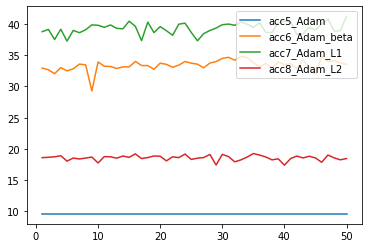

In [26]:
    figure, z = plt.subplots(1, 1)
    z.plot(range(1, 51), accuracy5, label='acc5_Adam')
    z.plot(range(1, 51), accuracy6, label='acc6_Adam_beta')
    z.plot(range(1, 51), accuracy7, label='acc7_Adam_L1')
    z.plot(range(1, 51), accuracy8, label='acc8_Adam_L2')
    plt.legend(['acc5_Adam', 'acc6_Adam_beta', 'acc7_Adam_L1', 'acc8_Adam_L2'], loc='upper right')	
    plt.show()

2) Question 2

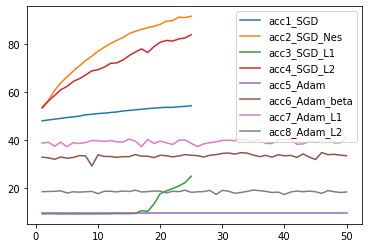

In [27]:
    figure, compare = plt.subplots(1, 1)
    compare.plot(range(1, 26), accuracy_array[0], label='acc1_SGD')
    compare.plot(range(1, 26), accuracy_array[1], label='acc2_SGD_Nes')
    compare.plot(range(1, 26), accuracy_array[2], label='acc3_SGD_L1')
    compare.plot(range(1, 26), accuracy_array[3], label='acc4_SGD_L2')
    compare.plot(range(1, 51), accuracy5, label='acc5_Adam')
    compare.plot(range(1, 51), accuracy6, label='acc6_Adam_beta')
    compare.plot(range(1, 51), accuracy7, label='acc7_Adam_L1')
    compare.plot(range(1, 51), accuracy8, label='acc8_Adam_L2')   
    plt.legend(['acc1_SGD', 'acc2_SGD_Nes', 'acc3_SGD_L1', 'acc4_SGD_L2', 'acc5_Adam', 'acc6_Adam_beta', 'acc7_Adam_L1', 'acc8_Adam_L2'], loc='upper right')
    plt.show()

Except SGD-L1 regulizer, Adam is not very sufficient and better than SGD. 

3) Question 3

In [28]:
    model9 = Network().to(DEVICE)
    model10 = Network().to(DEVICE)
    model11 = Network().to(DEVICE)
    model12 = Network().to(DEVICE)
    model13 = Network().to(DEVICE)

In [29]:
    optimizer9 = torch.optim.Adam(model9.parameters(), lr=0.1, betas=(0.9,0.99))
    loss9 = []
    loss9_val = 0
    for epoch in range(25):
        avg_loss9 = train(model9, train_loader, optimizer9, epoch, None)
        loss9.append(avg_loss9)
        loss9_val += avg_loss9
    print('avg_loss9: ', loss9_val/len(loss9))

epoch: 1 and loss: 92.23811348251343
epoch: 2 and loss: 2.3101479957580566
epoch: 3 and loss: 2.3095389420318604
epoch: 4 and loss: 2.3084945699310304
epoch: 5 and loss: 2.3089226195526122
epoch: 6 and loss: 2.3082727896881106
epoch: 7 and loss: 2.3087502195739744
epoch: 8 and loss: 2.3082577309417727
epoch: 9 and loss: 2.3097508699798586
epoch: 10 and loss: 2.3089505502319336
epoch: 11 and loss: 2.3093684413146973
epoch: 12 and loss: 2.3088898767089843
epoch: 13 and loss: 2.309522166748047
epoch: 14 and loss: 2.3091797785949706
epoch: 15 and loss: 2.308969154510498
epoch: 16 and loss: 2.308919810333252
epoch: 17 and loss: 2.309219631652832
epoch: 18 and loss: 2.3090740046691893
epoch: 19 and loss: 2.3092598609924315
epoch: 20 and loss: 2.308537978973389
epoch: 21 and loss: 2.3082302825164795
epoch: 22 and loss: 2.308338639526367
epoch: 23 and loss: 2.3081802768707274
epoch: 24 and loss: 2.308911507873535
epoch: 25 and loss: 2.308615672988892
avg_loss9:  5.906096674179078


In [30]:
    optimizer10 = torch.optim.Adam(model10.parameters(), lr=0.01, betas=(0.9,0.99))
    loss10 = []
    loss10_val = 0
    for epoch in range(25):
        avg_loss10 = train(model10, train_loader, optimizer10, epoch, None)
        loss10.append(avg_loss10)
        loss10_val += avg_loss10
    print('avg_loss10: ', loss10_val/len(loss10))

epoch: 1 and loss: 2.2367984057617187
epoch: 2 and loss: 1.957803609275818
epoch: 3 and loss: 1.9446082083892822
epoch: 4 and loss: 1.936851770629883
epoch: 5 and loss: 1.9288895516967774
epoch: 6 and loss: 1.928012686843872
epoch: 7 and loss: 1.9341836532211303
epoch: 8 and loss: 1.9225312872695923
epoch: 9 and loss: 1.931732805633545
epoch: 10 and loss: 1.9305047007751466
epoch: 11 and loss: 1.9253136337280274
epoch: 12 and loss: 1.9283578781509398
epoch: 13 and loss: 1.9282009911346436
epoch: 14 and loss: 1.9176414950942993
epoch: 15 and loss: 1.9200082321166991
epoch: 16 and loss: 1.9136931331634521
epoch: 17 and loss: 1.92070401763916
epoch: 18 and loss: 1.9181134381103515
epoch: 19 and loss: 1.9180113397216796
epoch: 20 and loss: 1.9209490732574463
epoch: 21 and loss: 1.9231560485839845
epoch: 22 and loss: 1.9202965259552003
epoch: 23 and loss: 1.917077806739807
epoch: 24 and loss: 1.9145929144668579
epoch: 25 and loss: 1.920226410560608
avg_loss10:  1.9383303847167968


In [31]:
    optimizer11 = torch.optim.Adam(model11.parameters(), lr=0.001, betas=(0.9,0.99))
    loss11 = []
    loss11_val = 0
    for epoch in range(25):
        avg_loss11 = train(model11, train_loader, optimizer11, epoch, None)
        loss11.append(avg_loss11)
        loss11_val += avg_loss11
    print('avg_loss11: ', loss11_val/len(loss11))

epoch: 1 and loss: 1.8512486752700805
epoch: 2 and loss: 1.6605484454345703
epoch: 3 and loss: 1.564750283317566
epoch: 4 and loss: 1.5046094270324708
epoch: 5 and loss: 1.459042197303772
epoch: 6 and loss: 1.4159231898880005
epoch: 7 and loss: 1.387468501815796
epoch: 8 and loss: 1.3544393486404418
epoch: 9 and loss: 1.3215465314483643
epoch: 10 and loss: 1.2999349698257445
epoch: 11 and loss: 1.264481999053955
epoch: 12 and loss: 1.2435671759033202
epoch: 13 and loss: 1.222206071243286
epoch: 14 and loss: 1.1989928003692627
epoch: 15 and loss: 1.1737365488815308
epoch: 16 and loss: 1.1530202642059326
epoch: 17 and loss: 1.1246992650222778
epoch: 18 and loss: 1.115814285106659
epoch: 19 and loss: 1.088674942779541
epoch: 20 and loss: 1.07613487865448
epoch: 21 and loss: 1.049583631248474
epoch: 22 and loss: 1.0383326592826843
epoch: 23 and loss: 1.010113191833496
epoch: 24 and loss: 0.9960878260803223
epoch: 25 and loss: 0.9788388470077515
avg_loss11:  1.262151838265991


In [32]:
    optimizer12 = torch.optim.Adam(model12.parameters(), lr=0.0001, betas=(0.9,0.99))
    loss12 = []
    loss12_val = 0
    for epoch in range(25):
        avg_loss12 = train(model12, train_loader, optimizer12, epoch, None)
        loss12.append(avg_loss12)
        loss12_val += avg_loss12
    print('avg_loss12: ', loss12_val/len(loss12))

epoch: 1 and loss: 1.9295880130386354
epoch: 2 and loss: 1.7422566889190674
epoch: 3 and loss: 1.6540618476867677
epoch: 4 and loss: 1.5979993564224244
epoch: 5 and loss: 1.5607384426879882
epoch: 6 and loss: 1.5222346522140502
epoch: 7 and loss: 1.4873289151382447
epoch: 8 and loss: 1.4641674766921997
epoch: 9 and loss: 1.4364730117034912
epoch: 10 and loss: 1.4124008107376098
epoch: 11 and loss: 1.3896478346633911
epoch: 12 and loss: 1.3697381990814208
epoch: 13 and loss: 1.3475594646835327
epoch: 14 and loss: 1.3260244735336304
epoch: 15 and loss: 1.3065746920776367
epoch: 16 and loss: 1.2902337630844116
epoch: 17 and loss: 1.2724355934906006
epoch: 18 and loss: 1.2518785260772705
epoch: 19 and loss: 1.2352539408493042
epoch: 20 and loss: 1.226947758140564
epoch: 21 and loss: 1.206106803741455
epoch: 22 and loss: 1.1898370956039428
epoch: 23 and loss: 1.1751089269638062
epoch: 24 and loss: 1.1601697942352296
epoch: 25 and loss: 1.1461040480804443
avg_loss12:  1.3880348051818852


In [33]:
    optimizer13 = torch.optim.Adam(model13.parameters(), lr=0.0001, betas=(0.9,0.99))
    loss13 = []
    loss13_val = 0
    for epoch in range(25):
        avg_loss13 = train(model13, train_loader, optimizer13, epoch, None)
        loss13.append(avg_loss13)
        loss13_val += avg_loss13
    print('avg_loss13: ', loss13_val/len(loss13))

epoch: 1 and loss: 1.931315012512207
epoch: 2 and loss: 1.7384073781585694
epoch: 3 and loss: 1.6531966498184205
epoch: 4 and loss: 1.5989943185043336
epoch: 5 and loss: 1.5504204837799072
epoch: 6 and loss: 1.5157666944122314
epoch: 7 and loss: 1.4839532012939454
epoch: 8 and loss: 1.4550086805725098
epoch: 9 and loss: 1.4277817132949828
epoch: 10 and loss: 1.4080996059417725
epoch: 11 and loss: 1.3827437437820436
epoch: 12 and loss: 1.3625185457229614
epoch: 13 and loss: 1.3394759172821045
epoch: 14 and loss: 1.3231086284637452
epoch: 15 and loss: 1.30622191696167
epoch: 16 and loss: 1.2833086533355713
epoch: 17 and loss: 1.26975481300354
epoch: 18 and loss: 1.2496464812469483
epoch: 19 and loss: 1.2345473907470703
epoch: 20 and loss: 1.2189902991867065
epoch: 21 and loss: 1.2076719784927368
epoch: 22 and loss: 1.1879534136199952
epoch: 23 and loss: 1.1726879138946533
epoch: 24 and loss: 1.1608441973495482
epoch: 25 and loss: 1.1457067408370971
avg_loss13:  1.384324974888611


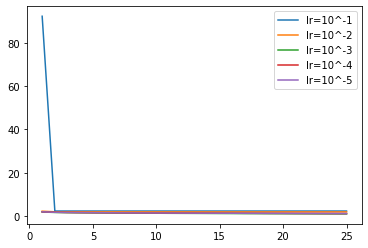

In [34]:
    figure2, m1 = plt.subplots(1, 1)
    m1.plot(range(1, 26), loss9, label='lr=10^-1')
    m1.plot(range(1, 26), loss10, label='lr=10^-2')
    m1.plot(range(1, 26), loss11, label='lr=10^-3')
    m1.plot(range(1, 26), loss12, label='lr=10^-4')
    m1.plot(range(1, 26), loss13, label='lr=10^-5')
    plt.legend(['lr=10^-1', 'lr=10^-2', 'lr=10^-3', 'lr=10^-4', 'lr=10^-5'], loc='upper right')	
    plt.show()

In [35]:
    print('Accuracy 9')
    accuracy9 = []
    acc9_val = 0
    for epoch in range(25):
        avg_accuracy9 = evaluate(model9, test_loader, optimizer9)
        accuracy9.append(avg_accuracy9)
        acc9_val += avg_accuracy9
    print('avg_acc9: %', (acc9_val/len(accuracy9)).cpu().numpy())
    
    print('\nAccuracy 10')
    accuracy10 = []
    acc10_val = 0
    for epoch in range(25):
        avg_accuracy10 = evaluate(model10, test_loader, optimizer10)
        accuracy10.append(avg_accuracy10)
        acc10_val += avg_accuracy10
    print('avg_acc10: %', (acc10_val/len(accuracy10)).cpu().numpy())
    
    print('\nAccuracy 11')
    accuracy11 = []
    acc11_val = 0
    for epoch in range(25):
        avg_accuracy11 = evaluate(model11, test_loader, optimizer11)
        accuracy11.append(avg_accuracy11)
        acc11_val += avg_accuracy11
    print('avg_acc11: %', (acc11_val/len(accuracy11)).cpu().numpy())
    
    print('\nAccuracy 12')
    accuracy12 = []
    acc12_val = 0
    for epoch in range(25):
        avg_accuracy12 = evaluate(model12, test_loader, optimizer12)
        accuracy12.append(avg_accuracy12)
        acc12_val += avg_accuracy12
    print('avg_acc12: %', (acc12_val/len(accuracy12)).cpu().numpy())

    print('\nAccuracy 13')
    accuracy13 = []
    acc13_val = 0
    for epoch in range(25):
        avg_accuracy13 = evaluate(model13, test_loader, optimizer13)
        accuracy13.append(avg_accuracy13)
        acc13_val += avg_accuracy13
    print('avg_acc13: %', (acc13_val/len(accuracy13)).cpu().numpy())

Accuracy 9
Average loss: 2.323751774597168, Accuracy: 953.0/10000 = 10%
Average loss: 2.312003447723389, Accuracy: 991.0/10000 = 10%
Average loss: 2.309246754074097, Accuracy: 976.0/10000 = 10%
Average loss: 2.309224509048462, Accuracy: 978.0/10000 = 10%
Average loss: 2.3092402282714843, Accuracy: 978.0/10000 = 10%
Average loss: 2.309247764205933, Accuracy: 978.0/10000 = 10%
Average loss: 2.309251014328003, Accuracy: 978.0/10000 = 10%
Average loss: 2.3092525390625, Accuracy: 978.0/10000 = 10%
Average loss: 2.3092531066894533, Accuracy: 978.0/10000 = 10%
Average loss: 2.309253444290161, Accuracy: 978.0/10000 = 10%
Average loss: 2.309253507232666, Accuracy: 978.0/10000 = 10%
Average loss: 2.3092536060333253, Accuracy: 978.0/10000 = 10%
Average loss: 2.3092535846710205, Accuracy: 978.0/10000 = 10%
Average loss: 2.309253596878052, Accuracy: 978.0/10000 = 10%
Average loss: 2.3092536190032957, Accuracy: 978.0/10000 = 10%
Average loss: 2.309253609085083, Accuracy: 978.0/10000 = 10%
Average lo

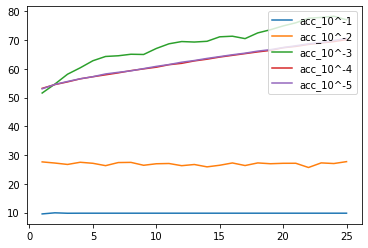

In [36]:
    figure2, m2 = plt.subplots(1, 1)
    m2.plot(range(1, 26), accuracy9, label='acc_10^-1')
    m2.plot(range(1, 26), accuracy10, label='acc_10^-2')
    m2.plot(range(1, 26), accuracy11, label='acc_10^-3')
    m2.plot(range(1, 26), accuracy12, label='acc_10^-4')
    m2.plot(range(1, 26), accuracy13, label='acc_10^-5')
    plt.legend(['acc_10^-1', 'acc_10^-2', 'acc_10^-3', 'acc_10^-4', 'acc_10^-5'], loc='upper right')	
    plt.show()

4) Question 4

In [37]:
    rand_k = 10**-(np.random.uniform(1, 5, size=5))
    print('random varıables for 10^-x: ', rand_k)

    model14 = Network().to(DEVICE)
    model15 = Network().to(DEVICE)
    model16 = Network().to(DEVICE)
    model17 = Network().to(DEVICE)
    model18 = Network().to(DEVICE)

random varıables for 10^-x:  [0.04486433 0.00240687 0.05049928 0.00522008 0.00642449]


In [38]:
    optimizer14 = torch.optim.Adam(model14.parameters(), lr=rand_k[0], betas=(0.9,0.99))
    loss14 = []
    loss14_val = 0
    for epoch in range(25):
        avg_loss14 = train(model14, train_loader, optimizer14, epoch, None)
        loss14.append(avg_loss14)
        loss14_val += avg_loss14
    print('avg_loss14: ', loss14_val/len(loss14))

epoch: 1 and loss: 13.931687992401123
epoch: 2 and loss: 2.305111173248291
epoch: 3 and loss: 2.305861563339233
epoch: 4 and loss: 2.30504981552124
epoch: 5 and loss: 2.3059211167907714
epoch: 6 and loss: 2.3056913980865477
epoch: 7 and loss: 2.30559970413208
epoch: 8 and loss: 2.3056019802856444
epoch: 9 and loss: 2.3053071006774903
epoch: 10 and loss: 2.30552032951355
epoch: 11 and loss: 2.3053686183166504
epoch: 12 and loss: 2.3057736528015136
epoch: 13 and loss: 2.305752910308838
epoch: 14 and loss: 2.30551533782959
epoch: 15 and loss: 2.305576711654663
epoch: 16 and loss: 2.3053304383850097
epoch: 17 and loss: 2.3053492596435547
epoch: 18 and loss: 2.3057951288604737
epoch: 19 and loss: 2.3055837522888183
epoch: 20 and loss: 2.3060131234741212
epoch: 21 and loss: 2.30554806022644
epoch: 22 and loss: 2.305164976501465
epoch: 23 and loss: 2.3057379219055174
epoch: 24 and loss: 2.306184712677002
epoch: 25 and loss: 2.3054433374023438
avg_loss14:  2.770619604650879


In [39]:
    optimizer15 = torch.optim.Adam(model15.parameters(), lr=rand_k[0], betas=(0.9,0.99))
    loss15 = []
    loss15_val = 0
    for epoch in range(25):
        avg_loss15 = train(model15, train_loader, optimizer15, epoch, None)
        loss15.append(avg_loss15)
        loss15_val += avg_loss15
    print('avg_loss15: ', loss15_val/len(loss15))

epoch: 1 and loss: 10.128252902069091
epoch: 2 and loss: 2.3055368775177003
epoch: 3 and loss: 2.305631360397339
epoch: 4 and loss: 2.306380435333252
epoch: 5 and loss: 2.3053154349517824
epoch: 6 and loss: 2.3050724543762207
epoch: 7 and loss: 2.305776663818359
epoch: 8 and loss: 2.305820104827881
epoch: 9 and loss: 2.305163988647461
epoch: 10 and loss: 2.3051489185333254
epoch: 11 and loss: 2.3054913800811767
epoch: 12 and loss: 2.3054738600158693
epoch: 13 and loss: 2.3057890071105955
epoch: 14 and loss: 2.305729015426636
epoch: 15 and loss: 2.30546045173645
epoch: 16 and loss: 2.3060380534362794
epoch: 17 and loss: 2.3054424118041994
epoch: 18 and loss: 2.305455725326538
epoch: 19 and loss: 2.3053963222503664
epoch: 20 and loss: 2.305963923110962
epoch: 21 and loss: 2.3058468112182617
epoch: 22 and loss: 2.305638491973877
epoch: 23 and loss: 2.305746032485962
epoch: 24 and loss: 2.3058480838775637
epoch: 25 and loss: 2.3056009369659423
avg_loss15:  2.618520785891724


In [40]:
    optimizer16 = torch.optim.Adam(model16.parameters(), lr=rand_k[0], betas=(0.9,0.99))
    loss16 = []
    loss16_val = 0
    for epoch in range(25):
        avg_loss16 = train(model16, train_loader, optimizer16, epoch, None)
        loss16.append(avg_loss16)
        loss16_val += avg_loss16
    print('avg_loss16: ', loss16_val/len(loss16))

epoch: 1 and loss: 12.216591796340943
epoch: 2 and loss: 2.3055431983184813
epoch: 3 and loss: 2.3053906924438476
epoch: 4 and loss: 2.304953865890503
epoch: 5 and loss: 2.3059178234100344
epoch: 6 and loss: 2.305872069320679
epoch: 7 and loss: 2.3055747132873536
epoch: 8 and loss: 2.3053985678863524
epoch: 9 and loss: 2.3056773461914064
epoch: 10 and loss: 2.304974273300171
epoch: 11 and loss: 2.30581263381958
epoch: 12 and loss: 2.3056440867614745
epoch: 13 and loss: 2.30534940864563
epoch: 14 and loss: 2.305417696914673
epoch: 15 and loss: 2.305823444671631
epoch: 16 and loss: 2.3054853291320803
epoch: 17 and loss: 2.305931479644775
epoch: 18 and loss: 2.305732106399536
epoch: 19 and loss: 2.3051306083679197
epoch: 20 and loss: 2.3058059616851807
epoch: 21 and loss: 2.3051294751739504
epoch: 22 and loss: 2.3053124225616455
epoch: 23 and loss: 2.305634437866211
epoch: 24 and loss: 2.3051755586242675
epoch: 25 and loss: 2.3058398003387452
avg_loss16:  2.701964751879883


In [41]:
    optimizer17 = torch.optim.Adam(model17.parameters(), lr=rand_k[0], betas=(0.9,0.99))
    loss17 = []
    loss17_val = 0
    for epoch in range(25):
        avg_loss17 = train(model17, train_loader, optimizer17, epoch, None)
        loss17.append(avg_loss17)
        loss17_val += avg_loss17
    print('avg_loss17: ', loss17_val/len(loss17))

epoch: 1 and loss: 12.12140961341858
epoch: 2 and loss: 2.3092408107757567
epoch: 3 and loss: 2.3046797731018067
epoch: 4 and loss: 2.3056921448516845
epoch: 5 and loss: 2.3054787422180176
epoch: 6 and loss: 2.3051091546630857
epoch: 7 and loss: 2.305580967941284
epoch: 8 and loss: 2.3054426008605957
epoch: 9 and loss: 2.3053720987701416
epoch: 10 and loss: 2.3060057443237305
epoch: 11 and loss: 2.305510252609253
epoch: 12 and loss: 2.3057375199890138
epoch: 13 and loss: 2.3056010555267332
epoch: 14 and loss: 2.3052290586853026
epoch: 15 and loss: 2.3053655504608153
epoch: 16 and loss: 2.30587261428833
epoch: 17 and loss: 2.305885999298096
epoch: 18 and loss: 2.3057090412902834
epoch: 19 and loss: 2.305760199661255
epoch: 20 and loss: 2.305510659942627
epoch: 21 and loss: 2.3054245482635496
epoch: 22 and loss: 2.3054507469177246
epoch: 23 and loss: 2.3056143663024904
epoch: 24 and loss: 2.305359758682251
epoch: 25 and loss: 2.3053132830810545
avg_loss17:  2.6982942522369395


In [42]:
    optimizer18 = torch.optim.Adam(model18.parameters(), lr=rand_k[0], betas=(0.9,0.99))
    loss18 = []
    loss18_val = 0
    for epoch in range(25):
        avg_loss18 = train(model18, train_loader, optimizer18, epoch, None)
        loss18.append(avg_loss18)
        loss18_val += avg_loss18
    print('avg_loss18: ', loss18_val/len(loss18))

epoch: 1 and loss: 13.369508974456787
epoch: 2 and loss: 2.305557727203369
epoch: 3 and loss: 2.30596676071167
epoch: 4 and loss: 2.3050599015808104
epoch: 5 and loss: 2.305622734603882
epoch: 6 and loss: 2.3056183124542238
epoch: 7 and loss: 2.306246951751709
epoch: 8 and loss: 2.3050930407714842
epoch: 9 and loss: 2.30548037979126
epoch: 10 and loss: 2.305814780807495
epoch: 11 and loss: 2.30537341545105
epoch: 12 and loss: 2.305395835418701
epoch: 13 and loss: 2.3054605307006835
epoch: 14 and loss: 2.305515177764893
epoch: 15 and loss: 2.3054047575378416
epoch: 16 and loss: 2.3056630178833006
epoch: 17 and loss: 2.3058355455017088
epoch: 18 and loss: 2.3053600174713136
epoch: 19 and loss: 2.3057812829589843
epoch: 20 and loss: 2.3052068280792235
epoch: 21 and loss: 2.3056142272186277
epoch: 22 and loss: 2.3054237413024903
epoch: 23 and loss: 2.3056204298400877
epoch: 24 and loss: 2.3057065450286864
epoch: 25 and loss: 2.3057707334136963
avg_loss18:  2.748124065988159


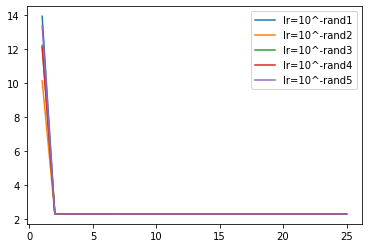

In [43]:
    figure2, m1 = plt.subplots(1, 1)
    m1.plot(range(1, 26), loss14, label='lr=10^-rand1')
    m1.plot(range(1, 26), loss15, label='lr=10^-rand2')
    m1.plot(range(1, 26), loss16, label='lr=10^-rand3')
    m1.plot(range(1, 26), loss17, label='lr=10^-rand4')
    m1.plot(range(1, 26), loss18, label='lr=10^-rand5')
    plt.legend(['lr=10^-rand1', 'lr=10^-rand2', 'lr=10^-rand3', 'lr=10^-rand4', 'lr=10^-rand5'], loc='upper right')	
    plt.show()

In [44]:
    print('Accuracy 14')
    accuracy14 = []
    acc14_val = 0
    for epoch in range(25):
        avg_accuracy14 = evaluate(model14, test_loader, optimizer14)
        accuracy14.append(avg_accuracy14)
        acc14_val += avg_accuracy14
    print('avg_acc14: %', (acc14_val/len(accuracy14)).cpu().numpy())
    
    print('\nAccuracy 15')
    accuracy15 = []
    acc15_val = 0
    for epoch in range(25):
        avg_accuracy15 = evaluate(model15, test_loader, optimizer15)
        accuracy15.append(avg_accuracy15)
        acc15_val += avg_accuracy15
    print('avg_acc15: %', (acc15_val/len(accuracy15)).cpu().numpy())
    
    print('\nAccuracy 16')
    accuracy16 = []
    acc16_val = 0
    for epoch in range(25):
        avg_accuracy16 = evaluate(model16, test_loader, optimizer16)
        accuracy16.append(avg_accuracy16)
        acc16_val += avg_accuracy16
    print('avg_acc16: %', (acc16_val/len(accuracy16)).cpu().numpy())
    
    print('\nAccuracy 17')
    accuracy17 = []
    acc17_val = 0
    for epoch in range(25):
        avg_accuracy17 = evaluate(model17, test_loader, optimizer17)
        accuracy17.append(avg_accuracy17)
        acc17_val += avg_accuracy17
    print('avg_acc17: %', (acc17_val/len(accuracy17)).cpu().numpy())

    print('\nAccuracy 18')
    accuracy18 = []
    acc18_val = 0
    for epoch in range(25):
        avg_accuracy18 = evaluate(model18, test_loader, optimizer18)
        accuracy18.append(avg_accuracy18)
        acc18_val += avg_accuracy18
    print('avg_acc18: %', (acc18_val/len(accuracy18)).cpu().numpy())

Accuracy 14
Average loss: 2.3546049545288086, Accuracy: 984.0/10000 = 10%
Average loss: 2.305856404876709, Accuracy: 982.0/10000 = 10%
Average loss: 2.3058274181365968, Accuracy: 982.0/10000 = 10%
Average loss: 2.3058229484558104, Accuracy: 985.0/10000 = 10%
Average loss: 2.305821022033691, Accuracy: 988.0/10000 = 10%
Average loss: 2.3058201721191405, Accuracy: 990.0/10000 = 10%
Average loss: 2.3058198085784913, Accuracy: 987.0/10000 = 10%
Average loss: 2.3058196685791015, Accuracy: 987.0/10000 = 10%
Average loss: 2.3058195442199705, Accuracy: 987.0/10000 = 10%
Average loss: 2.3058195064544678, Accuracy: 987.0/10000 = 10%
Average loss: 2.3058195274353026, Accuracy: 987.0/10000 = 10%
Average loss: 2.305819527053833, Accuracy: 987.0/10000 = 10%
Average loss: 2.305819520950317, Accuracy: 987.0/10000 = 10%
Average loss: 2.3058195274353026, Accuracy: 987.0/10000 = 10%
Average loss: 2.30581947555542, Accuracy: 987.0/10000 = 10%
Average loss: 2.3058195178985597, Accuracy: 987.0/10000 = 10%
Av

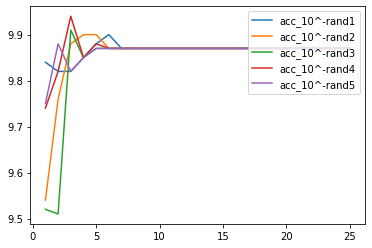

In [45]:
    figure2, m2 = plt.subplots(1, 1)
    m2.plot(range(1, 26), accuracy14, label='acc_10^-rand1')
    m2.plot(range(1, 26), accuracy15, label='acc_10^-rand2')
    m2.plot(range(1, 26), accuracy16, label='acc_10^-rand3')
    m2.plot(range(1, 26), accuracy17, label='acc_10^-rand4')
    m2.plot(range(1, 26), accuracy18, label='acc_10^-rand5')
    plt.legend(['acc_10^-rand1', 'acc_10^-rand2', 'acc_10^-rand3', 'acc_10^-rand4', 'acc_10^-rand5'], loc='upper right')	
    plt.show()

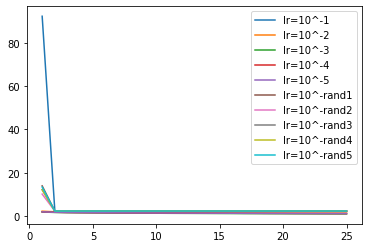

In [46]:
    figure2, compare1 = plt.subplots(1, 1)
    compare1.plot(range(1, 26), loss9, label='lr=10^-1')
    compare1.plot(range(1, 26), loss10, label='lr=10^-2')
    compare1.plot(range(1, 26), loss11, label='lr=10^-3')
    compare1.plot(range(1, 26), loss12, label='lr=10^-4')
    compare1.plot(range(1, 26), loss13, label='lr=10^-5')
    compare1.plot(range(1, 26), loss14, label='lr=10^-rand1')
    compare1.plot(range(1, 26), loss15, label='lr=10^-rand2')
    compare1.plot(range(1, 26), loss16, label='lr=10^-rand3')
    compare1.plot(range(1, 26), loss17, label='lr=10^-rand4')
    compare1.plot(range(1, 26), loss18, label='lr=10^-rand5')
    plt.legend(['lr=10^-1', 'lr=10^-2', 'lr=10^-3', 'lr=10^-4', 'lr=10^-5', 'lr=10^-rand1', 'lr=10^-rand2', 'lr=10^-rand3', 'lr=10^-rand4', 'lr=10^-rand5'], loc='upper right')	
    plt.show()

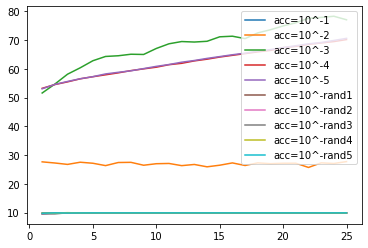

In [47]:
    figure2, compare2 = plt.subplots(1, 1)
    compare2.plot(range(1, 26), accuracy9, label='acc=10^-1')
    compare2.plot(range(1, 26), accuracy10, label='acc=10^-2')
    compare2.plot(range(1, 26), accuracy11, label='acc=10^-3')
    compare2.plot(range(1, 26), accuracy12, label='acc=10^-4')
    compare2.plot(range(1, 26), accuracy13, label='acc=10^-5')
    compare2.plot(range(1, 26), accuracy14, label='acc=10^-rand1')
    compare2.plot(range(1, 26), accuracy15, label='acc=10^-rand2')
    compare2.plot(range(1, 26), accuracy16, label='acc=10^-rand3')
    compare2.plot(range(1, 26), accuracy17, label='acc=10^-rand4')
    compare2.plot(range(1, 26), accuracy18, label='acc=10^-rand5')
    plt.legend(['acc=10^-1', 'acc=10^-2', 'acc=10^-3', 'acc=10^-4', 'acc=10^-5', 'acc=10^-rand1', 'acc=10^-rand2', 'acc=10^-rand3', 'acc=10^-rand4', 'acc=10^-rand5'], loc='upper right')	
    plt.show()